# TimeSeries Forecasting @Datalift Conference Workshop in Berlin - Elia Group

created by the Center of Excellence AI Elia Group (Christian Merz, Thomas Craessaerts, Raphael Croegaert, Rachel Berryman)  

Link to the app: https://share.streamlit.io/chris-elia/ts-forecast/main/main.py  


Contact: Artificialintelligence@eliagroup.eu

### Agenda ###
0. (**Set-up environment**)

1. **Exploring the data**  🔍  
 1.1. Elia Open Data (Total Load, PV and Wind production)  
 1.2 Rebase API Weather Forecast  
 1.3 Quick Visualization of the Data  
 
1. **Time Series forecasting with Prophet** 📈   
 2.1 Univariate Forecasting  
 2.2 Multivariate Forecasting  

3. **Putting everything together in a Web App with Streamlit** 🚀  
   3.1   Layout & Functionalities  
   3.2 Streamlit Cloud Deployment



<img src="./data/Architecture_Layout.png" alt="Drawing" style="width: 1000px;"/>

### 0. Set-up dependencies

To run this notebook and the forecasting app, you need certain dependencies.  
To make it as simple as possible, everything is wrapped up in a conda environment file.
Therefore run the two following commands in command line:
- **conda env create -f environment.yml**
- **conda activate conda_timeseries_forecaster**

The first one will install the python version with the required packages. The second command will activate the conda environment.  



**Python Version**
- Python: 3.8.13
   
**Required packages**
- pip install streamlit
- pip install pystan==2.19.1.1
- conda install prophet



###     1. Exploring the data from the Elia OpenData Platform 🔍 


https://opendata.elia.be/pages/home/ 

    
https://api.rebase.energy/weather/docs/v2/

https://realto.io/api-marketplace/

#### 1.1. Elia Open DataAPI

**Total Load:** https://opendata.elia.be/explore/dataset/ods003/api/

**PV production:** https://opendata.elia.be/explore/dataset/ods032/api

**Wind production:** https://opendata.elia.be/explore/dataset/ods031/api


In [16]:
#### Import of the neccessary libraries ###
import requests
import pandas as pd

def get_open_data_elia_df(dataset, start_date, end_date):
    """Gets and returns the selected dataset from the Elia Open Data Platform within a given time range

    Parameters
    ----------
    dataset: str
        the selected dataset identifier from the Elia Open Data Platform
    start_date: str
        The start date of the selected dataset, Format: "YYYY-MM-DD"
    end_date: str
        The end date of the selected dataset, Format: "YYYY-MM-DD"    
    

    Returns
    -------
    pd.Dataframe
        a dataframe containing the selected data
    
    """

    url = f"https://opendata.elia.be/api/v2/catalog/datasets/{dataset}/exports/"
    json_string = f"json?where=datetime in [date'{start_date}' .. date'{end_date}']"
    
    response = requests.get(url = url + json_string)

    # calling the Elia Open Data API
    df = pd.DataFrame(response.json())
    
    df.sort_values(by = "datetime", inplace = True)
    df.reset_index(inplace = True, drop =  True)    
    df["datetime"] = pd.to_datetime(df["datetime"]).dt.tz_localize(None)

    return df



**Test the Open Data Function**

In [17]:
dataset = "ods003"
start_date = "2022-06-03"
end_date = "2022-06-05"
df_open_data = get_open_data_elia_df(dataset, start_date , end_date )
df_open_data.head()

,datetime,resolutioncode,eliagridload
0,2022-06-03 00:00:00,PT15M,6641.334
1,2022-06-03 00:15:00,PT15M,6639.778
2,2022-06-03 00:30:00,PT15M,6581.803
3,2022-06-03 00:45:00,PT15M,6537.082
4,2022-06-03 01:00:00,PT15M,6598.935


#### 1.2 Rebase Weather Forecast

In [18]:
def get_weather_forecast(start_date, end_date, latitude, longitude):
    
    secret = "W-cRKEYdwzL6mdWCYO2_UZSOWI1MxET07dquSY9Fck4"
    """
    Gets and returns the weather forecast from rebase within a given time range

    Parameters
    ----------
    start_date: str
        The start date of the selected dataset, Format: "YYYY-MM-DD"
    end_date: str
        The end date of the selected dataset, Format: "YYYY-MM-DD"
    latitude: str
        The latitude value (Geo location) of the city for the weather forecast
    longitude: str
        The longitude value (Geo location) of the city for the weather forecast

    Returns
    -------
    pd.Dataframe
        a dataframe containing the selected data
    
    """

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Authentication
    url = "https://api.rebase.energy/weather/v2/query"
    headers = {"Authorization": secret } ## to be changed to st.secrets["REBASE_KEY"]
    params = {
        'model': 'FMI_HIRLAM',
        'start-date': start_date,
        'end-date': end_date,
        'reference-time-freq': '24H',
        'forecast-horizon': 'latest',
        'latitude': latitude,
        'longitude': longitude,
        'variables': 'Temperature, WindSpeed, SolarDownwardRadiation'
    }
    response = requests.get(url, headers=headers, params=params)

    # Clean data
    df = pd.DataFrame(response.json())
    df = df.drop('ref_datetime', axis=1)
    df["valid_datetime"] = pd.to_datetime(df["valid_datetime"]).dt.tz_localize(None)

    df = df.rename(columns={'valid_datetime': 'datetime'})
    df = df.drop_duplicates(keep='last')
    df = df.fillna(0)

    return df
  


**Test Weather Forecast Rebase** 

In [19]:
start_date = "2022-06-03"
end_date = "2022-06-05"
latitude = "50.85045"
longitude = "4.34878"
df_weather = get_weather_forecast(start_date, end_date, latitude, longitude)

df_weather.head()

,datetime,SolarDownwardRadiation,Temperature,WindSpeed
0,2022-06-03 00:00:00,0.00,12.96,4.21
1,2022-06-03 01:00:00,0.00,12.29,3.54
2,2022-06-03 02:00:00,0.00,11.08,2.92
3,2022-06-03 03:00:00,0.00,10.02,2.76
4,2022-06-03 04:00:00,3.41,9.23,2.55


### 1.3 Quick Visualization of the Data

<AxesSubplot:title={'center':'Total Load in the Elia Grid'}, xlabel='Time', ylabel='MW'>

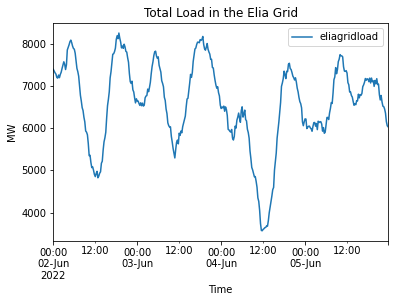

In [20]:
df_grid_load = get_open_data_elia_df("ods003", "2022-06-02", "2022-06-05")
df_grid_load = df_grid_load.loc[:,["datetime", "eliagridload"]]
#df_ts.set_index("datetime", inplace=True)
df_grid_load.plot(
    x = df_grid_load.columns[0],
    y = df_grid_load.columns[1],
    title = "Total Load in the Elia Grid",
    ylabel = "MW",
    xlabel = "Time"
)

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

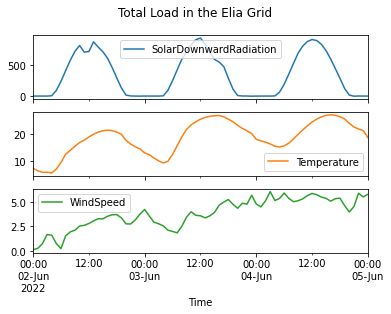

In [21]:
df_weather = get_weather_forecast("2022-06-02", "2022-06-05", latitude = "50.85045", longitude = "4.34878")
#df_weather = df_weather.loc[:,["datetime", "eliagridload"]]
#df_ts.set_index("datetime", inplace=True)
df_weather.plot(
    x = df_weather.columns[0],
    y = [df_weather.columns[1],df_weather.columns[2],df_weather.columns[3]],
    title = "Total Load in the Elia Grid",
    xlabel = "Time",
    subplots = True
)

**What we have achived so far**

<img src="./data/Architecture_Layout Step 2.png" alt="Drawing" style="width: 700px;"/>

## 2. Timeseries Forecasting with Prophet (Facebook) 📈  

The Prophet library is an open-source library designed for making forecasts for univariate time series datasets.
It is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

**Documentation:** https://facebook.github.io/prophet/docs/quick_start.html

#### Univariate Forecasting

Tasks for you to do:

1. Get familiar with the Prophet API and make a simple prediction -> check out the documentation
2. Wrap everything together in a function

,Unnamed: 0,datetime,eliagridload
0,0,2022-06-02 00:00:00,7389.412
1,1,2022-06-02 00:15:00,7346.066
2,2,2022-06-02 00:30:00,7307.105
3,3,2022-06-02 00:45:00,7277.433
4,4,2022-06-02 01:00:00,7197.606


2022-06-02 00:00:00 2022-06-05 23:45:00


<AxesSubplot:xlabel='datetime'>

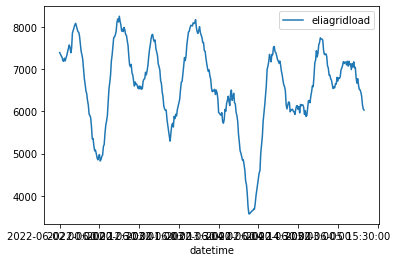

In [22]:
# 1. Get familiar with the Prophet API and make a simple prediction -> check out the documentation

import pandas 
from prophet import Prophet

# read in the test_data_grid.csv file as a dataframe 
df = pd.read_csv('./data/test_data_grid.csv')

# have a quick look at the data
display(df.head())
print(df.datetime.min(), df.datetime.max())

df.plot("datetime", "eliagridload")

In [23]:

# rename the columns of the dataframe to the Prophet convention
prophet_df = pd.DataFrame().assign(ds=df.datetime, y=df.eliagridload)
prophet_df.head()


,ds,y
0,2022-06-02 00:00:00,7389.412
1,2022-06-02 00:15:00,7346.066
2,2022-06-02 00:30:00,7307.105
3,2022-06-02 00:45:00,7277.433
4,2022-06-02 01:00:00,7197.606


In [24]:

# creating a Prophet object 
    ## optional parameters can be set here like:
    ## seasonality, changepoints, uncertainty intervals etc. see help(Prophet) 
    ## e.g. weekly_seasonality = True
prophet_model = Prophet()

# Fit the data to the Prophet object
    ## fit() methods expects a dataframe with the column heads ds and y
prophet_model.fit(prophet_df)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-06-24 10:19:41.921 INFO    prophet: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-06-24 10:19:41.921 INFO    prophet: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -5.06779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.984   0.000558953       90.3917           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       775.683   0.000720135       90.4618   7.472e-06       0.001      235  LS failed, Hessian reset 
     199       775.977    0.00574711        77.722           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       776.187    0.00107096       79.1668           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       776.433   9.30127e-06       70.6254      0.5926      0.5926      536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       776.676     0.0010903    

/opt/homebrew/Caskroom/mambaforge/base/envs/ts_workshop/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


/opt/homebrew/Caskroom/mambaforge/base/envs/ts_workshop/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/Caskroom/mambaforge/base/envs/ts_workshop/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/Caskroom/mambaforge/base/envs/ts_workshop/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


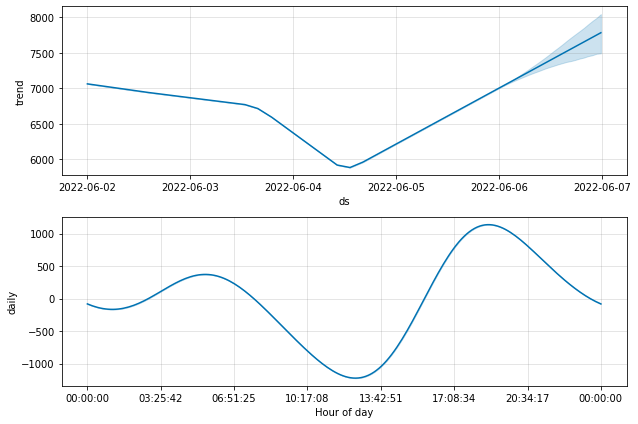

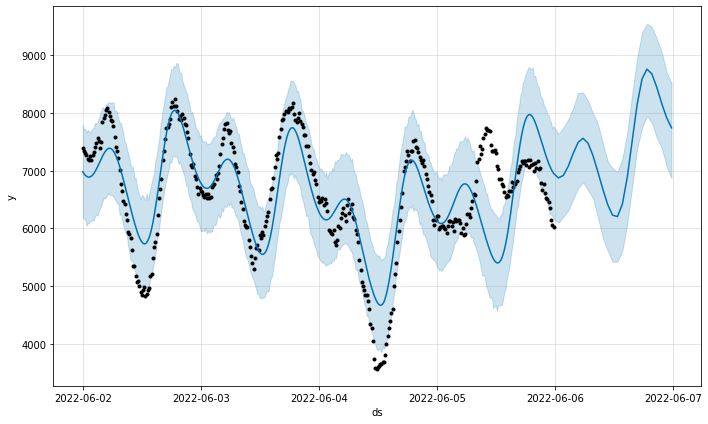

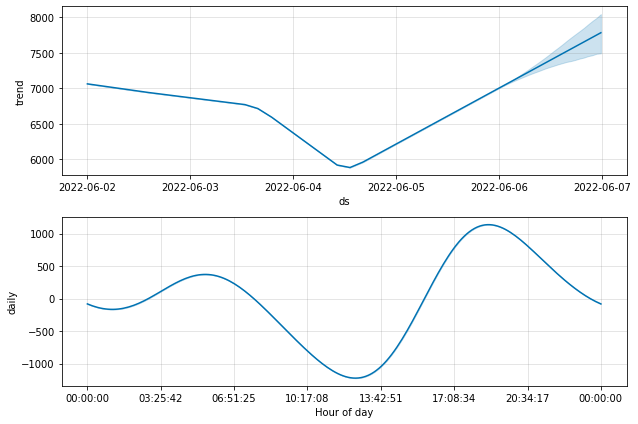

In [25]:

# Create the future dataframe and set the frequency to Hours
     ## periods: Int number of periods to forecast forward. 
     ## freq: Any valid frequency for pd.date_range, such as 'M (month), 'D'(day) or 'H' (hour).
future_df = prophet_model.make_future_dataframe(24, freq="H")

# Make the prediction
     ## expects a dataframe with dates for predictions 
     ## (created above with make_future_dataframe)
forecast = prophet_model.predict(future_df)
    
# Create some plots of the forecast
    ## forecast plot
prophet_model.plot(forecast)

    ## components plot
prophet_model.plot_components(forecast)

In [26]:
# 2. Wrap everything together in a function

from prophet import Prophet
import pandas as pd

def run_forecast_univariate(df, periods):
    """
    returns the univariate prophet forecast + two graphic objects (forecast & composite)

    Parameters
    ----------
    df: DataFrame
        a dataframe that includes the historical data
    periods: int
        the time steps to forecast

    Returns
    -------
    forecast
        a dataframe containing the foecast data
    fig_forecast
        a figure forecast to plot
    fig_components
        a figure components to plot
    
    """

    prophet_df = pd.DataFrame().assign(ds=df.datetime, y=df.eliagridload)

    prophet_model = Prophet()

    prophet_model.fit(prophet_df)
    future_df = prophet_model.make_future_dataframe(periods, freq="H")
    forecast = prophet_model.predict(future_df)
        
    fig_forecast = prophet_model.plot(forecast)

    fig_components = prophet_model.plot_components(forecast)
    
    return forecast, fig_forecast, fig_components

**Test Univariate Forecast**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-06-24 10:19:43.146 INFO    prophet: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-06-24 10:19:43.147 INFO    prophet: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/opt/homebrew/Caskroom/mambaforge/base/envs/ts_workshop/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/Caskroom/mambaforge/base/envs/ts_workshop/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com

Initial log joint probability = -5.06779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.984   0.000558953       90.3917           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       775.683   0.000720135       90.4618   7.472e-06       0.001      235  LS failed, Hessian reset 
     199       775.977    0.00574711        77.722           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       776.187    0.00107096       79.1668           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       776.433   9.30127e-06       70.6254      0.5926      0.5926      536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       776.676     0.0010903    

/opt/homebrew/Caskroom/mambaforge/base/envs/ts_workshop/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


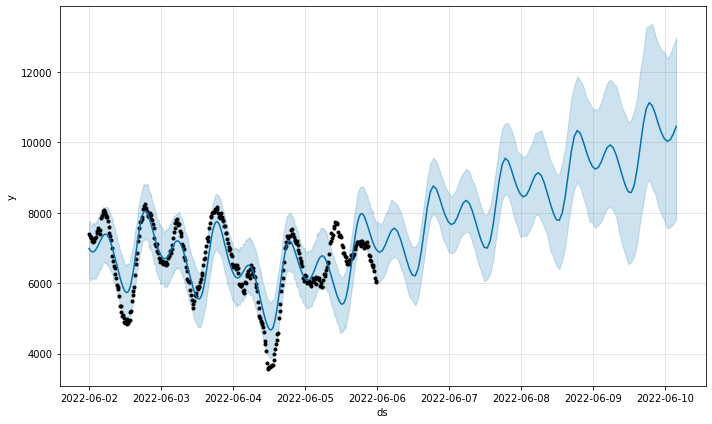

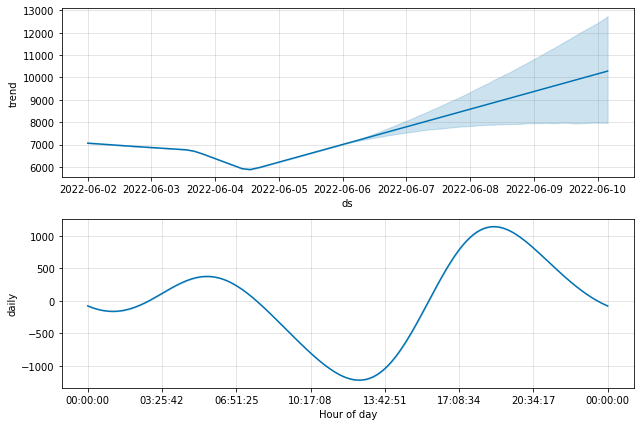

In [27]:
df_grid_load = get_open_data_elia_df("ods003", "2022-06-02", "2022-06-05")
df_grid_load = df_grid_load.loc[:,["datetime", "eliagridload"]]
forecast, fig_forecast, fig_comp = run_forecast_univariate(df_grid_load, 100)

print(fig_forecast)

**What we have achived so far**

<img src="./data/Architecture_Layout Step 3_5.png" alt="Drawing" style="width: 700px;"/>

#### Multivariate Forecasting

For multivariate forecasting we need additional features.   
In this example we **include the weather forecast** (solar radiation, wind speed and temperature) **as additional features**.  
Therefore we need to combine the historical data with the weather data. This is done with the function *prepare_data_for_mv_fc*

In [28]:
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from datetime import timedelta
import pandas as pd

from prophet.utilities import regressor_coefficients
# from modules.fetch_data import get_weather_forecast, get_open_data_elia_df


def prepare_data_for_mv_fc(dataset, start_date, end_date, solar: bool, wind: bool, temp: bool, lat: str, long: str):
    """
    Prepares and merges weather data with historical data for multivariate forecast with prophet

    Parameters
    ----------
    dataset: str
        the selected dataset identifier from the Elia Open Data Platform
    start_date: str
        The start date of the selected dataset, Format: "YYYY-MM-DD"
    end_date: str
        The end date of the selected dataset, Format: "YYYY-MM-DD"    
    solar: bool
        if True, solar data will be added as additional regressor
    wind: bool
        if True, wind data will be added as additional regressor
    temp: bool
        if True, temp data will be added as additional regressor
    lat: str
        The latitude value (Geo location) of the city for the weather forecast
    long: str
        The longitude value (Geo location) of the city for the weather forecast


    Returns
    -------
    pd.Dataframe
        a dataframe containing the merged historical and weather data
    

    """
    # catch open data
    if (dataset == "ods003"): # total load
        df = get_open_data_elia_df(dataset,start_date, end_date) 
        df.set_index(df["datetime"], inplace = True)
        df = df.resample("H").mean()
        df.reset_index(inplace = True)
        
    else:  # for solar & wind 
        df = get_open_data_elia_df(dataset,start_date, end_date) 
        df = df.groupby("datetime").sum()
        df = df.resample("H").mean()
        df.reset_index(inplace = True)
        df = df.loc[:,["datetime", "mostrecentforecast"]]
        df["datetime"] = pd.to_datetime(df["datetime"]).dt.tz_localize(None)

    # specifying variables
    start_date= df["datetime"].iloc[0]
    end_date = df["datetime"].iloc[-1]
    latitude = lat
    longitude = long

    # get weather forecast
    df_weather = get_weather_forecast(start_date, end_date, latitude, longitude)
    columns = []
    if solar:
        columns.append("SolarDownwardRadiation")
    if wind:  
        columns.append("WindSpeed")
    if temp:
        columns.append("Temperature")

    columns.append("datetime")
    df_weather = df_weather.loc[:,columns]    
    df_merged = df.merge(df_weather, on = "datetime")

    df_merged.rename(columns = {df.columns[0]: "ds", df.columns[1]:"y"}, inplace = True)

    return df_merged

**Task:**

Add two lines of code to the *run_forecast_multivariate* function to add the additional columns/features to the prophet model.

In [29]:
def run_forecast_multivariate(df_merged, lat, long, forecast_horizon):

    """
    returns the multivariate prophet forecast + two graphic objects (forecast & components) + regressor coeffiecnt dataframe

    Parameters
    ----------
    df_merged: DataFrame
        a dataframe that includes the historical data + 
    lat:
        latitude value of geo localization for weather forecast
    long:
        longitude value of geo localization for weather forecast
    forecast_horizon: int
        the time steps to forecast

    Returns
    -------
    forecast
        a dataframe containing the foecast data
    fig_forecast
        a figure forecast to plot
    fig_components
        a figure components to plot
    reg_coef
        a dataframe with the coefficiencts of the additional regressors

    """
    # date calculation
    end_date = df_merged["ds"].sort_values().iloc[-1] # last date of the historical data    
    start_date_forecast = end_date + timedelta(hours = 1) # first date for the forecast
    end_date_forecast = start_date_forecast + timedelta(hours = forecast_horizon) # last date for the forecast

    # get weather forecast
    weather_forecast = get_weather_forecast(start_date_forecast, end_date_forecast, lat, long)
    
    # creating Prophet Object
    m = Prophet() 
    
    # creating an addiitional regressor for each additional column that is provided
        ## create a for loop that loops through the additional columns of df_merged
        # use the .add_regressor() function to add the additional columns to the prophet model
    
    for col in df_merged:
        if col not in ["ds", "y"]:
            m.add_regressor(col)
            
    # fit() methods expects a dataframe with the column heads ds and y
    # fits the prophet model to the data
    m.fit(df_merged)

    # Definition of forecast range
    ## periods: Int number of periods to forecast forward. 
    ## req: Any valid frequency for pd.date_range, such as 'D' or 'M'.
    future = m.make_future_dataframe(periods=forecast_horizon, freq = "H")
    future = future.merge(weather_forecast, left_on= "ds", right_on = "datetime")

    # Prediction
    ## expects a dataframe with dates for predictions 
    ## (created above with make_future_dataframe)
    forecast = m.predict(future)

    # plotting
    fig_forecast = m.plot(forecast)
    fig_components = m.plot_components(forecast)

    reg_coef = regressor_coefficients(m)
    
    return forecast, fig_forecast, fig_components, reg_coef


**Test the Multivariate Forecast Function**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-06-24 10:19:45.893 INFO    prophet: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-06-24 10:19:45.895 INFO    prophet: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/opt/homebrew/Caskroom/mambaforge/base/envs/ts_workshop/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/Caskroom/mambaforge/base/envs/ts_workshop/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com


Initial log joint probability = -70.9258
Iteration  1. Log joint probability =    86.4129. Improved by 157.339.
Iteration  2. Log joint probability =    152.089. Improved by 65.6766.
Iteration  3. Log joint probability =    189.827. Improved by 37.7373.
Iteration  4. Log joint probability =    213.683. Improved by 23.8562.
Iteration  5. Log joint probability =    218.732. Improved by 5.04945.
Iteration  6. Log joint probability =    218.817. Improved by 0.0846602.
Iteration  7. Log joint probability =    218.881. Improved by 0.0640794.
Iteration  8. Log joint probability =     218.97. Improved by 0.08853.
Iteration  9. Log joint probability =    219.085. Improved by 0.114887.
Iteration 10. Log joint probability =    219.136. Improved by 0.05184.
Iteration 11. Log joint probability =    219.257. Improved by 0.12089.
Iteration 12. Log joint probability =    219.284. Improved by 0.0263551.
Iteration 13. Log joint probability =    219.656. Improved by 0.37241.
Iteration 14. Log joint prob

/opt/homebrew/Caskroom/mambaforge/base/envs/ts_workshop/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


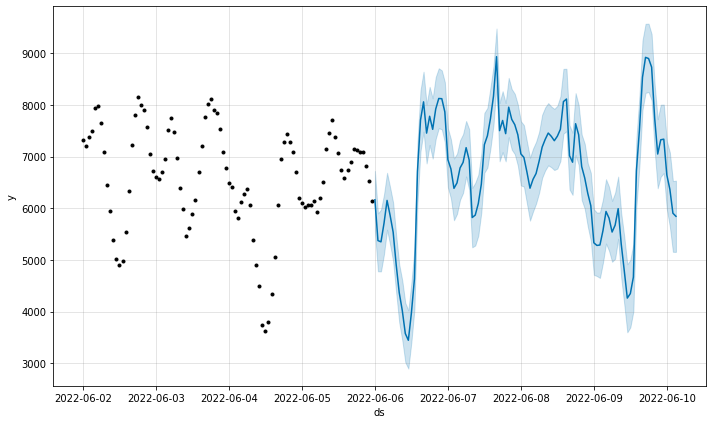

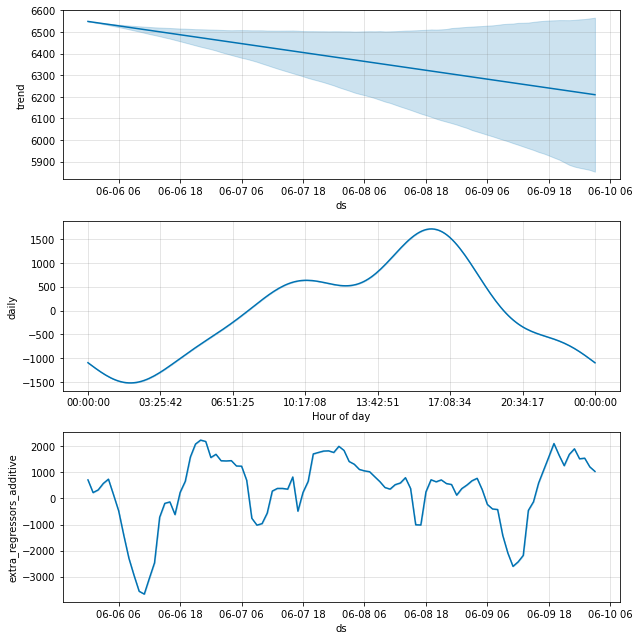

In [30]:
lat = "50.85045"
long = "4.34878"
forecast_horizon = 100

df_merged = prepare_data_for_mv_fc("ods003", "2022-06-02", "2022-06-05", True, True, False, lat, long)
forecast, fig_forecast, fig_components, reg_coef = run_forecast_multivariate(df_merged, lat, long, forecast_horizon)

print(fig_forecast)

**What we have achived so far**

<img src="./data/Architecture_Layout Step 3.png" alt="Drawing" style="width: 700px;"/>

## Putting everything together in a Web App with Streamlit 🚀

Let's move to Visual Studio Code and implement the functions and create the layout.

Therefore we have organised the described functions above in seperate .py files

<img src="./data/Architecture_Layout Step 4.png" alt="Drawing" style="width: 700px;"/>